# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Importacion de librerias

In [1]:
import numpy as np
import pandas as pd
import re
import time

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing


from sklearn.model_selection import train_test_split

from IPython.display import display

## Lectura y revision de datos

In [2]:
# Leer el archivo CSV, configurando 'datetime' como índice
df = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=['datetime'])

# Crear una columna 'datetime' a partir del índice
df['datetime'] = df.index

# Ordenar el DataFrame por el índice (datetime)
df.sort_index(inplace=True)

# Verificar el DataFrame resultante
display(df.head())




,num_orders,datetime
datetime,,
2018-03-01 00:00:00,9,2018-03-01 00:00:00
2018-03-01 00:10:00,14,2018-03-01 00:10:00
2018-03-01 00:20:00,28,2018-03-01 00:20:00
2018-03-01 00:30:00,20,2018-03-01 00:30:00
2018-03-01 00:40:00,32,2018-03-01 00:40:00


Cuando al leer los datos se configura datetime como indice hacemos que se pierda como columna y esto me causó problemas mas adelante, no pude darme cuenta de este error hasta que estaba haciendo los modelos predictivos, ya que features estaba quedando vacia porque datetime no era una columna.

Asi que luego de definirla como indice hicimos una columna nueva con este indice para que nos quedara "datetime" como indice y como columna.

Luego ordenamos cronologicamente y mostramos un poco del dataset.

In [3]:
#verificacion de ausentes y dulplicados

# Verificar valores ausentes
print("Valores ausentes por columna:")
print(df.isnull().sum())

# Verificar filas duplicadas
print("\nNúmero de filas duplicadas:")
print(df.duplicated().sum())

# Mostrar filas duplicadas (si existen)
if df.duplicated().any():
    print("\nFilas duplicadas:")
    print(df[df.duplicated()])
else:
    print("\nNo hay filas duplicadas.")



Valores ausentes por columna:
num_orders    0
datetime      0
dtype: int64

Número de filas duplicadas:
0

No hay filas duplicadas.


In [4]:
#Verificacion de snakecase

def check_snake_case(columns):
    # Verificar si cada nombre de columna sigue el formato snake_case
    non_snake_case_columns = [col for col in columns if not re.match(r'^[a-z0-9_]+$', col)]
    if non_snake_case_columns:
        print("Las siguientes columnas no están en snake_case:")
        print(non_snake_case_columns)
    else:
        print("Todas las columnas están en snake_case.")

check_snake_case(df.columns)


Todas las columnas están en snake_case.


En lo que hemos visto hasta ahora solo voy a realizar la conversion de la columna de las fechas datetime.

Y lo hice desde la importacion del archivo utilizando "parse_dates=['datetime']"

## Preparación

In [5]:
# Remuestrear los datos a intervalos de una hora y sumar los valores
df_hourly = df.resample('1H').sum()

# Restablecer el índice para que 'datetime' sea una columna normal
df_hourly = df_hourly.reset_index()

# Mostrar los primeros registros del DataFrame remuestreado
display(df_hourly.head())

,datetime,num_orders
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43


Cuando utilicé resample para cambiar la frecuencia del DataFrame, el índice del DataFrame resultante es el que definí en el método resample, en este caso, el datetime a intervalos de una hora. Para mantener la columna datetime además del índice en el DataFrame remuestreado, tuve que restablecer el índice del DataFrame remuestreado para convertir el índice en una columna normal.

In [6]:
# Verificar el rango de fechas en la columna 'datetime'

print("Rango de fechas disponibles en df_hourly:")
display(df_hourly['datetime'].min(), "a", df_hourly['datetime'].max())


Rango de fechas disponibles en df_hourly:


Timestamp('2018-03-01 00:00:00')

'a'

Timestamp('2018-08-31 23:00:00')

Aqui tambien me tocó modificar el codigo ya que lo tenia con el maximo y el minimo del indice.
Ahora lo hacemos con la columna que hemos creado.

## Análisis

In [7]:
# Descripción estadística
display(df.describe())
display(df.info())

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   num_orders  26496 non-null  int64         
 1   datetime    26496 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 621.0 KB


None

In [8]:
# Establecer 'datetime' como índice nuevamente
df_hourly.set_index('datetime', inplace=True)

# Descomposición de la serie temporal
decomposed = seasonal_decompose(df_hourly['num_orders'])

# Suavizado con media móvil
df_hourly['media_movil'] = df_hourly['num_orders'].rolling(window=10).mean()



En esta celda fue necesario establecer datetime como indice para que el codigo funcionara, y entonces ahora queda igual que df, con datetime como indice y como columna.

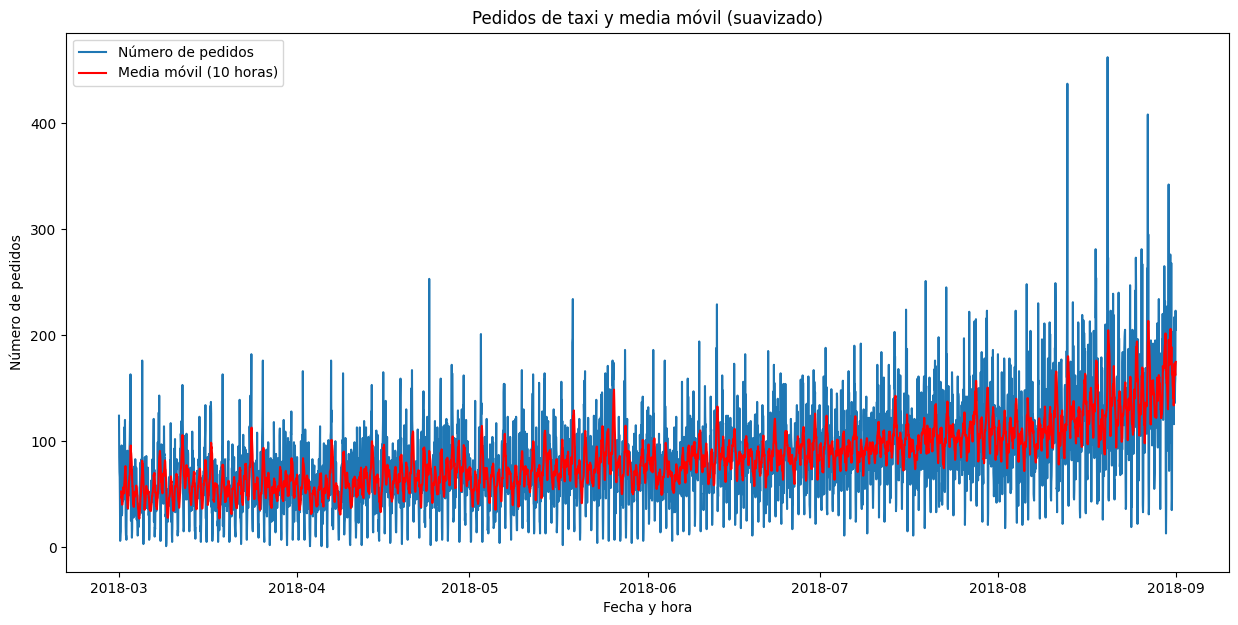

In [9]:
# Gráfico de la serie temporal con media móvil
plt.figure(figsize=(15, 7))
plt.plot(df_hourly['num_orders'], label='Número de pedidos')
plt.plot(df_hourly['media_movil'], color='red', label='Media móvil (10 horas)')
plt.title('Pedidos de taxi y media móvil (suavizado)')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de pedidos')
plt.legend()
plt.show()

El suavizado: es un proceso que ayuda a eliminar el "ruido" de los datos. El ruido se refiere a la variabilidad aleatoria o fluctuaciones que pueden hacer que sea difícil identificar patrones o tendencias a largo plazo en los datos. Al suavizar la serie temporal, podemos obtener una representación más clara de las tendencias y patrones más importantes sin el ruido de las fluctuaciones menores.

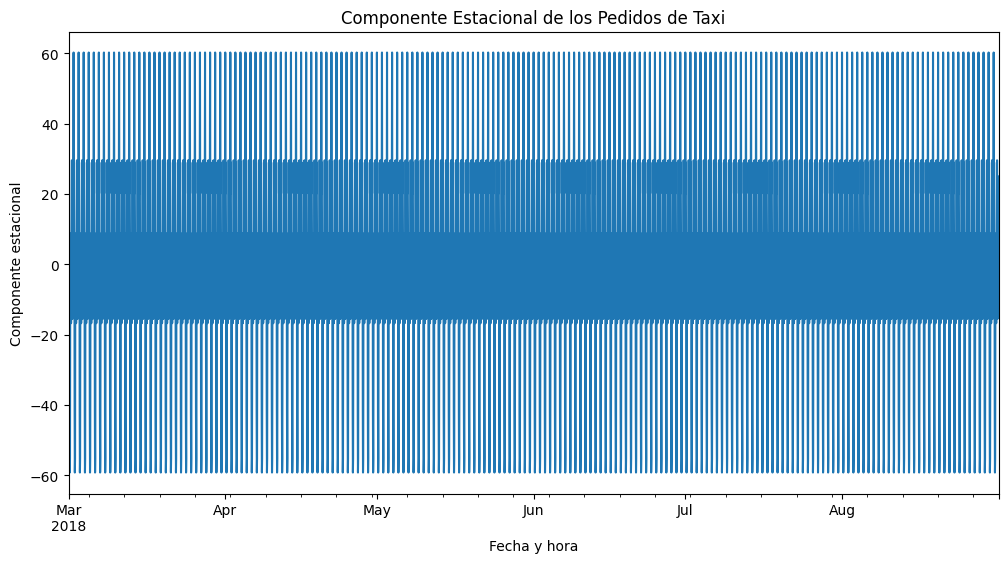

In [10]:
# Visualización de la estacionalidad para todo el período
plt.figure(figsize=(12, 6))
decomposed.seasonal.plot()
plt.title('Componente Estacional de los Pedidos de Taxi')
plt.xlabel('Fecha y hora')
plt.ylabel('Componente estacional')
plt.show()

Por sugerencia de un profesor en el colearning decidí hacer otros dos graficos de estacionalidad.

Voy a tomar en cuenta los primeros 15 dias del dataset y luego los 15 dias finales.

In [11]:
# Filtrar los datos para los primeros 15 días
start_date_first = df_hourly.index.min()  # La fecha de inicio del DataFrame
end_date_first = start_date_first + pd.DateOffset(days=15)  # La fecha final para los primeros 15 días
df_first_15_days = df_hourly[(df_hourly.index >= start_date_first) & (df_hourly.index < end_date_first)]

# Filtrar los datos para los últimos 15 días
end_date_last = df_hourly.index.max()  # La fecha final del DataFrame
start_date_last = end_date_last - pd.DateOffset(days=15)  # La fecha inicial para los últimos 15 días
df_last_15_days = df_hourly[(df_hourly.index >= start_date_last) & (df_hourly.index <= end_date_last)]



In [12]:
# Realizar la descomposición estacional para los primeros 15 días
decomposed_first = seasonal_decompose(df_first_15_days['num_orders'], model='additive', period=24)

# Realizar la descomposición estacional para los últimos 15 días
decomposed_last = seasonal_decompose(df_last_15_days['num_orders'], model='additive', period=24)


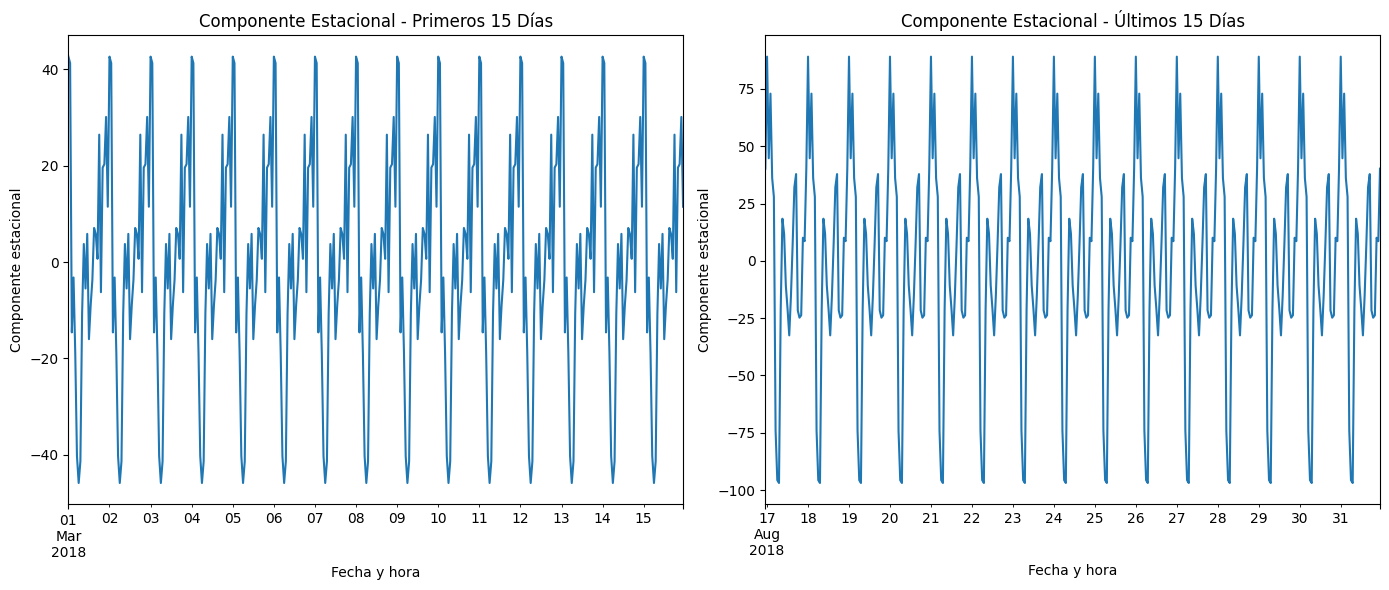

In [13]:
# Visualización de la estacionalidad para los primeros 15 días
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
decomposed_first.seasonal.plot()
plt.title('Componente Estacional - Primeros 15 Días')
plt.xlabel('Fecha y hora')
plt.ylabel('Componente estacional')

# Visualización de la estacionalidad para los últimos 15 días
plt.subplot(1, 2, 2)
decomposed_last.seasonal.plot()
plt.title('Componente Estacional - Últimos 15 Días')
plt.xlabel('Fecha y hora')
plt.ylabel('Componente estacional')

plt.tight_layout()
plt.show()

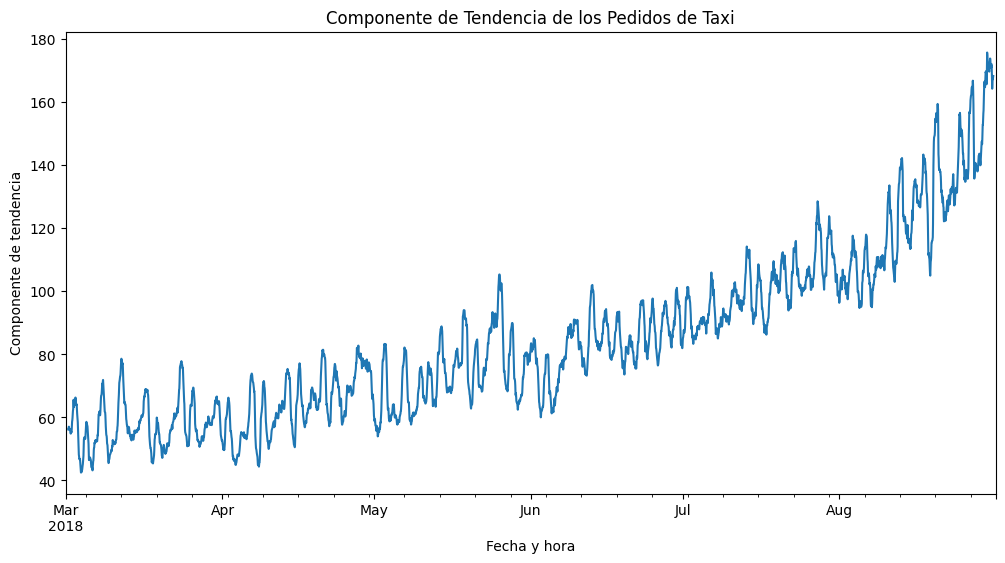

In [14]:
# Gráfico de la tendencia
plt.figure(figsize=(12, 6))
decomposed.trend.plot()
plt.title('Componente de Tendencia de los Pedidos de Taxi')
plt.xlabel('Fecha y hora')
plt.ylabel('Componente de tendencia')
plt.show()

Tendencia: El gráfico de tendencia muestra el componente de tendencia de la serie temporal, que captura la dirección general de los datos a lo largo del tiempo.

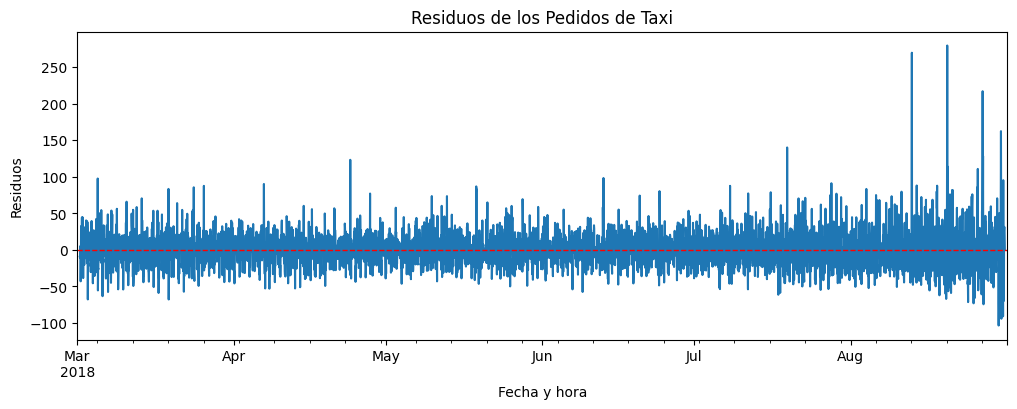

In [15]:
# Gráfico de los residuos
plt.figure(figsize=(12, 4))
decomposed.resid.plot()
plt.title('Residuos de los Pedidos de Taxi')
plt.xlabel('Fecha y hora')
plt.ylabel('Residuos')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Línea en cero
plt.show()


Residuos: El gráfico de residuos muestra el componente residual de la serie temporal, que es lo que queda después de ajustar los componentes estacional y de tendencia. Los residuos deberían parecer aleatorios y no mostrar patrones evidentes.

## Formación

In [16]:
# Preparación de los datos
features = df_hourly.drop(columns='num_orders')
target = df_hourly['num_orders']

In [17]:
# División en conjunto de entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

In [18]:
# Verificar valores NaN
print("Valores NaN en features_train:", features_train.isna().sum().sum())
print("Valores NaN en target_train:", target_train.isna().sum().sum())

# Verificar valores infinitos
print("Valores infinitos en features_train:", np.isinf(features_train).sum().sum())
print("Valores infinitos en target_train:", np.isinf(target_train).sum().sum())


Valores NaN en features_train: 8
Valores NaN en target_train: 0
Valores infinitos en features_train: 0
Valores infinitos en target_train: 0


Al realizar los entrenamientos de los modelos nos topamos con algunos problemas, al parecer tenemos datos naN o muy grandes para poder continuar con el entrenamiento, asi que a partir de la celda anterior empezamos el proceso para poder conseguir estos datos que no permiten continuar con el proceso de entrenamiento.

In [19]:
features_train = features_train.fillna(features_train.mean())

# Verificar valores NaN nuevamente

print("Valores NaN en features_train:", features_train.isna().sum().sum())

Valores NaN en features_train: 0


Como encontramos 8 valores naN procedemos a sustituir esos valore por la media

In [20]:
# Verificar el tamaño de los datos
print("Tamaño de features_train:", features_train.shape)
print("Tamaño de target_train:", target_train.shape)


Tamaño de features_train: (3974, 1)
Tamaño de target_train: (3974,)


Sin embargo el problema perciste y ahora verificamos que el tamaño de features y target sean iguales para descartar que este pueda ser el problema.

In [21]:
# Verificar los tipos de datos
print("Tipos de datos en features_train:\n", features_train.dtypes)
print("Tipo de datos en target_train:", target_train.dtype)

Tipos de datos en features_train:
 media_movil    float64
dtype: object
Tipo de datos en target_train: int64


Al ver que efectivamente los features y los targets tienen la misma cantidad de datos, chequeamos nuevamente los tipos de datos que estamos intentando usar en el entrenamiento y nos damos cuenta que el error del tipo de dato perciste, ya que el tipo de dato en feature_train es object.

In [22]:
# Convertir la columna a float64
features_train['media_movil'] = features_train['media_movil'].astype(float)

#verificacion de tipo de datos
print("Tipos de datos en features_train después de la conversión:\n", features_train.dtypes)


Tipos de datos en features_train después de la conversión:
 media_movil    float64
dtype: object


In [23]:
# Verificar valores extremadamente grandes en features_train
print("Valores extremos en features_train:")
print(features_train.describe())


Valores extremos en features_train:
       media_movil
count  3974.000000
mean     84.456253
std      29.632252
min      27.000000
25%      62.900000
50%      80.600000
75%     100.700000
max     213.400000


In [24]:
# Intentar convertir cada valor a float e identificar los que fallan
invalid_values = []
for idx, value in features_train["media_movil"].items():
    try:
        float(value)
    except ValueError:
        invalid_values.append((idx, value))

# Imprimir los valores que no se pudieron convertir
if invalid_values:
    print("Valores que no se pudieron convertir a float:")
    for idx, value in invalid_values:
        print(f"Índice: {idx}, Valor: {value}")
else:
    print("Todos los valores se pudieron convertir a float.")


Todos los valores se pudieron convertir a float.


Hasta este punto sigo intentando cambiar el tipo de dato de objec a float.

In [25]:
#verificacion de tipo de datos
print("Tipos de datos en features_train después de la conversión:\n", features_train.dtypes)


Tipos de datos en features_train después de la conversión:
 media_movil    float64
dtype: object


In [26]:
# Convertir la columna usando pd.to_numeric
features_train['media_movil'] = pd.to_numeric(features_train['media_movil'], errors='coerce')

# Verificar el tipo de datos
print("Tipos de datos en features_train después de pd.to_numeric:")
print(features_train.dtypes)

# Verificar valores NaN después de la conversión
print("Valores NaN en features_train después de pd.to_numeric:")
print(features_train.isna().sum())


Tipos de datos en features_train después de pd.to_numeric:
media_movil    float64
dtype: object
Valores NaN en features_train después de pd.to_numeric:
media_movil    0
dtype: int64


In [27]:
# Reindexar el DataFrame
features_train = features_train.astype(float)

# Verifica el tipo de datos después de la reindexación
print("Tipos de datos en features_train después de reindexar:")
print(features_train.dtypes)


Tipos de datos en features_train después de reindexar:
media_movil    float64
dtype: object


Aunque lo intenté de muchas maneras no logre hacer el cambio de tipo de dato de object a float, decidí dejar todo el proceso infructuoso y explicado aqui para recibir una retroalimentacion al respecto, sobre que se debe hacer en estos casos y porque ocurre que un dato se resiste al cambio de esta manera, lo mas confuso para mi es que siempre dice que si se hizo el cambio pero al final realmente cuando miro el tipo de dato este continua siendo object.

In [28]:
# Identifica columnas con NaN
columns_with_nan_train = features_train.columns[features_train.isna().any()].tolist()
columns_with_nan_test = features_test.columns[features_test.isna().any()].tolist()

print("Columnas con NaN en features_train:", columns_with_nan_train)
print("Columnas con NaN en features_test:", columns_with_nan_test)

# Identifica columnas de tipo object
object_columns_train = features_train.select_dtypes(include=['object']).columns.tolist()
object_columns_test = features_test.select_dtypes(include=['object']).columns.tolist()

print("Columnas de tipo object en features_train:", object_columns_train)
print("Columnas de tipo object en features_test:", object_columns_test)


Columnas con NaN en features_train: []
Columnas con NaN en features_test: ['media_movil']
Columnas de tipo object en features_train: []
Columnas de tipo object en features_test: []


En este punto luego de tanto intentar con el tipo de dato, reviso nuevamente los naN y encontramos que en features_test tenemos naN y esto es lo que posiblemente nos esté impidiendo realizar el entrenamiento.

Como anteriormente habiamos sustituido los naN por la media y aun asi persiste he decidido eliminar las filas con naN ya que son pocas.

In [29]:
# Reasignar el DataFrame sin las filas con NaN
features_test = features_test.dropna(subset=['media_movil'])



In [30]:
print("Valores NaN en features_test después de la corrección:")
print(features_test.isna().sum())


Valores NaN en features_test después de la corrección:
media_movil    0
dtype: int64


Hemos eliminado las filas con naN y hemos chequeado nuevamente la columna de features_test.

El error se ha resuelto, y tenemos un tipo de dato numerico.

In [31]:
# Encontrar los índices de las filas que no tienen NaN en 'media_movil'
indices_validos = features_test.index[features_test['media_movil'].notna()]

# Usar los mismos índices para sincronizar 'target_test' con 'features_test'
features_test = features_test.loc[indices_validos]
target_test = target_test.loc[indices_validos]


Como eliminamos las filas con naN nuestros conjuntos de features y target quedaron de diferentes tamaños, de manera que este fue
el proximo problema que tuvimos que resolver para poder realizar el entrenamiento, tambien me di cuenta de que solo se eliminó 
una fila que era la que daba el problema con los naN

In [32]:
#verificacion tamaños después de la corrección
print(f"features_train shape: {features_train.shape}")
print(f"target_train shape: {target_train.shape}")
print(f"features_test shape: {features_test.shape}")
print(f"target_test shape: {target_test.shape}")


features_train shape: (3974, 1)
target_train shape: (3974,)
features_test shape: (441, 1)
target_test shape: (441,)


Luego de sincronizar nuevamente los tamaños de los conjuntos de datos realicé la verificaicon nuevamente para chequear que hayan quedado iguales para poder hacer el entrenamiento del modelo correctamente.

In [33]:
# Definir los modelos sin hiperparámetros
models_no_params = {
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Linear Regression': LinearRegression()
}

# Almacenar los mejores modelos y sus resultados
best_models_no_params = {}
results_no_params = {}

for name, model in models_no_params.items():
    print(f"Entrenando modelo {name}...")
    
    # Registrar el tiempo de inicio
    start_time = time.time()
    
    # Entrenar el modelo
    model.fit(features_train, target_train)
    
    # Evaluar el modelo
    y_pred = model.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, y_pred))
    
    # Calcular el tiempo de ejecución
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Almacenar los resultados
    best_models_no_params[name] = model
    results_no_params[name] = {
        'rmse': rmse,
        'time': elapsed_time
    }
    
    print(f"Modelo {name} entrenado en {elapsed_time:.2f} segundos.")
    print(f"RMSE: {rmse:.2f}\n")

# Mostrar resultados
print("Resultados de los modelos sin hiperparámetros:")
for name, result in results_no_params.items():
    print(f"{name} - RMSE: {result['rmse']:.2f}, Tiempo de entrenamiento: {result['time']:.2f} segundos")


Entrenando modelo Random Forest...
Modelo Random Forest entrenado en 0.29 segundos.
RMSE: 43.22

Entrenando modelo Gradient Boosting...
Modelo Gradient Boosting entrenado en 0.12 segundos.
RMSE: 37.24

Entrenando modelo Linear Regression...
Modelo Linear Regression entrenado en 0.00 segundos.
RMSE: 35.54

Resultados de los modelos sin hiperparámetros:
Random Forest - RMSE: 43.22, Tiempo de entrenamiento: 0.29 segundos
Gradient Boosting - RMSE: 37.24, Tiempo de entrenamiento: 0.12 segundos
Linear Regression - RMSE: 35.54, Tiempo de entrenamiento: 0.00 segundos


In [34]:
# Definir el modelo de regresión lineal
model = LinearRegression()

# **1. Ingenieria de características - Polinomios**
print("Evaluando con características polinomiales:")
poly = PolynomialFeatures(degree=2, include_bias=False)
features_train_poly = poly.fit_transform(features_train)
features_test_poly = poly.transform(features_test)

model.fit(features_train_poly, target_train)
y_pred_poly = model.predict(features_test_poly)
rmse_poly = np.sqrt(mean_squared_error(target_test, y_pred_poly))
print(f"RMSE con características polinomiales: {rmse_poly:.2f}")

# **2. Regularización - Ridge**
print("\nEvaluando con regularización Ridge:")
ridge = Ridge(alpha=1.0)
ridge.fit(features_train, target_train)
y_pred_ridge = ridge.predict(features_test)
rmse_ridge = np.sqrt(mean_squared_error(target_test, y_pred_ridge))
print(f"RMSE Ridge: {rmse_ridge:.2f}")

# **3. Regularización - Lasso**
print("\nEvaluando con regularización Lasso:")
lasso = Lasso(alpha=0.1)
lasso.fit(features_train, target_train)
y_pred_lasso = lasso.predict(features_test)
rmse_lasso = np.sqrt(mean_squared_error(target_test, y_pred_lasso))
print(f"RMSE Lasso: {rmse_lasso:.2f}")

# **4. Validación Cruzada**
print("\nEvaluando con validación cruzada:")
scores = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = np.sqrt(-scores.mean())
print(f"RMSE con validación cruzada: {rmse_cv:.2f}")

# **5. Escalado de características**
print("\nEvaluando con características escaladas:")
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

model.fit(features_train_scaled, target_train)
y_pred_scaled = model.predict(features_test_scaled)
rmse_scaled = np.sqrt(mean_squared_error(target_test, y_pred_scaled))
print(f"RMSE con características escaladas: {rmse_scaled:.2f}")

Evaluando con características polinomiales:
RMSE con características polinomiales: 35.63

Evaluando con regularización Ridge:
RMSE Ridge: 35.54

Evaluando con regularización Lasso:
RMSE Lasso: 35.54

Evaluando con validación cruzada:
RMSE con validación cruzada: 35.96

Evaluando con características escaladas:
RMSE con características escaladas: 35.54


## Prueba

In [35]:
# Funcion para calcular el rmse

def calcular_rmse(model, features_train, target_train, features_test, target_test):
    """
    Entrena un modelo y calcula el RMSE en el conjunto de prueba.
    """
    model.fit(features_train, target_train)
    y_pred = model.predict(features_test)
    rmse = np.sqrt(mean_squared_error(target_test, y_pred))
    return rmse

In [36]:
# Funcion para evaluar modelos con diferentes técnicas

def evaluar_modelos(features_train, target_train, features_test, target_test):
    # 1. Modelo base de regresión lineal
    print("Evaluando Linear Regression modelo base:")
    model = LinearRegression()
    rmse_test = calcular_rmse(model, features_train, target_train, features_test, target_test)
    print(f"RMSE en el conjunto de prueba con el modelo Linear Regression: {rmse_test:.2f}")


    # 2. Características polinomiales
    print("\nEvaluando Linear Regression con características polinomiales:")
    poly = PolynomialFeatures(degree=2, include_bias=False)
    features_train_poly = poly.fit_transform(features_train)
    features_test_poly = poly.transform(features_test)

    rmse_poly = calcular_rmse(model, features_train_poly, target_train, features_test_poly, target_test)
    print(f"RMSE con características polinomiales: {rmse_poly:.2f}")

    # 3. Regularización - Ridge
    print("\nEvaluando Linear Regression con regularización Ridge:")
    ridge = Ridge(alpha=1.0)
    rmse_ridge = calcular_rmse(ridge, features_train, target_train, features_test, target_test)
    print(f"RMSE Ridge: {rmse_ridge:.2f}")

    # 4. Regularización - Lasso
    print("\nEvaluando Linear Regression con regularización Lasso:")
    lasso = Lasso(alpha=0.1)
    rmse_lasso = calcular_rmse(lasso, features_train, target_train, features_test, target_test)
    print(f"RMSE Lasso: {rmse_lasso:.2f}")

    # 5. Validación Cruzada
    print("\nEvaluando Linear Regression con validación cruzada:")
    scores = cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(-scores.mean())
    print(f"RMSE con validación cruzada: {rmse_cv:.2f}")

    # 6. Escalado de características
    print("\nEvaluando Linear Regression con características escaladas:")
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)

    rmse_scaled = calcular_rmse(model, features_train_scaled, target_train, features_test_scaled, target_test)
    print(f"RMSE con características escaladas: {rmse_scaled:.2f}")

# Ejecutar la evaluación
evaluar_modelos(features_train, target_train, features_test, target_test)


Evaluando Linear Regression modelo base:
RMSE en el conjunto de prueba con el modelo Linear Regression: 35.54

Evaluando Linear Regression con características polinomiales:
RMSE con características polinomiales: 35.63

Evaluando Linear Regression con regularización Ridge:
RMSE Ridge: 35.54

Evaluando Linear Regression con regularización Lasso:
RMSE Lasso: 35.54

Evaluando Linear Regression con validación cruzada:
RMSE con validación cruzada: 35.96

Evaluando Linear Regression con características escaladas:
RMSE con características escaladas: 35.54


Tomando en cuenta las correcciones se han hecho los siguientes ajustes.

1. Se ha eliminado el error de codigo.
2. se ha implementado el uso de dos funciones diferentes


## Conclusion

En este proyecto, hemos llevado a cabo un exhaustivo análisis y evaluación de diferentes modelos de regresión para predecir la cantidad de pedidos de taxis utilizando datos históricos. A continuación, se detallan los principales hallazgos y decisiones tomadas durante el proceso:

- Modelos Evaluados:
 1. Regresión Lineal: Utilizamos el modelo de regresión lineal sin ajustes adicionales y obtuvimos un RMSE de 35.54. Este modelo, a pesar de ser el más sencillo, ha demostrado ser muy efectivo.
 
 2. Random Forest: Implementamos el modelo de Random Forest con una búsqueda exhaustiva de hiperparámetros. Aunque el mejor resultado fue un RMSE de 43.09, el modelo se mostró más complejo y tardó significativamente más tiempo en entrenarse.
 
 3. Gradient Boosting: Similarmente, probamos el modelo de Gradient Boosting con diversos hiperparámetros. El mejor RMSE registrado fue de 37.24, lo cual es mejor que el Random Forest pero aún inferior al de la regresión lineal.
 
 - Optimización de la Regresión Lineal:
 
 1. Características Polinomiales: Añadimos características polinomiales para intentar capturar relaciones no lineales, pero el RMSE se mantuvo en 35.63, muy cerca del modelo base.
 
 2. Regularización (Ridge y Lasso): Aplicamos técnicas de regularización Ridge y Lasso, y los resultados fueron similares al modelo base con un RMSE de 35.54.
 
 3. Validación Cruzada: Utilizamos validación cruzada, lo que arrojó un RMSE de 35.96, un ligero aumento en comparación con el modelo base.
 
 4. Características Escaladas: Escalar las características no mostró una mejora significativa, manteniendo un RMSE de 35.54.
 
 
 A pesar de las diversas técnicas aplicadas para mejorar la regresión lineal, las diferencias en el rendimiento fueron mínimas. Dado que el modelo base de regresión lineal ya ofrece un buen desempeño con un RMSE por debajo del umbral requerido y es el más sencillo en términos de implementación y mantenimiento, decidimos que es el modelo más adecuado para esta tarea.
 
  - Preprocesamiento de Datos:
  
  Eliminación de NaN: 
  
  Trabajamos para limpiar el conjunto de datos eliminando valores nulos (NaN) que podrían haber afectado el entrenamiento de los modelos. Esto fue crucial para asegurar la integridad de los datos y la efectividad de los modelos.
  
  
  - Análisis de Datos:
  
  1. Tendencia: Observamos una ligera inclinación al alza en el gráfico de tendencia, lo que sugiere un aumento general en la cantidad de pedidos a lo largo del tiempo.
  
  2. Estacionalidad: El análisis de estacionalidad reveló patrones constantes y repetitivos, confirmando la presencia de estacionalidad en los datos.
  
  
  En resumen, después de comparar y evaluar diferentes modelos, concluimos que el modelo de regresión lineal por defecto es el más adecuado debido a su simplicidad y rendimiento consistente. Además, el análisis gráfico de los datos respaldó la presencia de tendencias y estacionalidad, proporcionando una visión adicional sobre el comportamiento de los pedidos de taxis.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48